# 광고 데이터 살펴보기
- MAB 문제에 자주 사용되는 데이터 가운데 광고 노출/클릭 데이터가 있습니다.
- 주어진 context에서 어떤 광고를 보여줄지 선택하는 것을 Policy라고 볼 수 있습니다.
- 특정 광고를 보여주는 것이 action에 해당하고 노출 이후에 클릭이 일어나면 reward = 1, 그렇지 않다면 0이 됩니다.

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm
from scipy.stats import beta

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 광고 노출/클릭 데이터를 사용합니다
# https://www.kaggle.com/c/avazu-ctr-prediction

file_path = '../data/avazu-ctr-prediction/mab_ad_click.csv'

In [3]:
parse_date = lambda x : datetime.strptime(x, '%y%m%d%H')
ad_df = pd.read_csv(file_path, parse_dates = ['datetime'], date_parser = parse_date, header=0)

In [4]:
ad_df.head()

,id,click,datetime,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10010804179216291475,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,-1,79
1,10013076841337920650,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15702,320,50,1722,0,35,-1,79
2,100156980486870304,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,-1,79
3,10036789730923212176,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15703,320,50,1722,0,35,-1,79
4,10050938058905541797,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15707,320,50,1722,0,35,-1,79


In [5]:
# C14 컬럼이 광고의 소재 ID
ad_df.apply(lambda x: len(x.unique())).sort_values(ascending=False)

id                  160297
device_ip            64217
device_model          1026
C14                    362
datetime               240
C20                     93
C17                     88
C21                     32
C19                     32
C18                      4
device_conn_type         2
C15                      2
C16                      2
click                    2
device_type              1
app_category             1
app_domain               1
app_id                   1
site_category            1
site_domain              1
site_id                  1
banner_pos               1
C1                       1
device_id                1
dtype: int64

In [6]:
# simple한 구현을 위해서 광고 노출 시간과 광고 소재의 id를 활용합니다
mab_df = ad_df[['id', 'C14', 'datetime', 'click']]
mab_df = mab_df.rename(columns = {'C14': 'ad'}, inplace = False)

In [7]:
mab_df

,id,ad,datetime,click
0,10010804179216291475,15704,2014-10-21 00:00:00,0
1,10013076841337920650,15702,2014-10-21 00:00:00,0
2,100156980486870304,15706,2014-10-21 00:00:00,0
3,10036789730923212176,15703,2014-10-21 00:00:00,1
4,10050938058905541797,15707,2014-10-21 00:00:00,1
...,...,...,...,...
160292,9899837143248831576,22257,2014-10-30 23:00:00,1
160293,9905100583305466044,15706,2014-10-30 23:00:00,0
160294,9962540383484110617,22261,2014-10-30 23:00:00,0
160295,9964318073950212472,22676,2014-10-30 23:00:00,0


In [8]:
# 서빙 가능한 광고 362개
ad_list = mab_df['ad'].unique().tolist()
N = len(ad_list)
ad_list

[15704,
 15702,
 15706,
 15703,
 15707,
 15708,
 15699,
 15705,
 15701,
 6616,
 8330,
 21647,
 21612,
 20750,
 21667,
 20153,
 21694,
 21692,
 21666,
 21697,
 21671,
 21727,
 21738,
 21731,
 20273,
 21726,
 21725,
 21732,
 21741,
 21759,
 21761,
 21763,
 21762,
 21724,
 21757,
 21760,
 21758,
 21695,
 21747,
 20272,
 21751,
 21749,
 21746,
 20966,
 21790,
 20271,
 21662,
 21853,
 21842,
 21838,
 21844,
 21841,
 18945,
 15840,
 10738,
 10742,
 10740,
 10741,
 10743,
 10739,
 20131,
 20151,
 20751,
 20274,
 21848,
 21847,
 22114,
 21849,
 22118,
 22102,
 22106,
 22105,
 22113,
 22103,
 21869,
 22104,
 21846,
 22116,
 21851,
 21850,
 21845,
 22111,
 22109,
 22107,
 22112,
 22141,
 22140,
 18947,
 19668,
 20108,
 18949,
 21235,
 20970,
 19421,
 9248,
 20969,
 22254,
 22258,
 22256,
 22257,
 22260,
 22255,
 22259,
 22261,
 22246,
 22202,
 22244,
 22268,
 9438,
 20393,
 22332,
 22325,
 22288,
 18946,
 20392,
 20397,
 20396,
 20395,
 20391,
 20394,
 22267,
 22503,
 9436,
 22553,
 22552,
 1849

In [9]:
N

362

In [10]:
# 광고별 평균 CTR 데이터
ad_statistics = pd.DataFrame({
    'imp': mab_df.groupby('ad')['id'].nunique(),
    'click': mab_df.groupby('ad')['click'].sum(),
    'ctr': mab_df.groupby('ad')['click'].mean()
}).reset_index()

ad_statistics.head()

,ad,imp,click,ctr
0,6616,637,76,0.119309
1,8330,579,80,0.138169
2,9248,1,0,0.000000
3,9436,4,0,0.000000
4,9438,6,0,0.000000


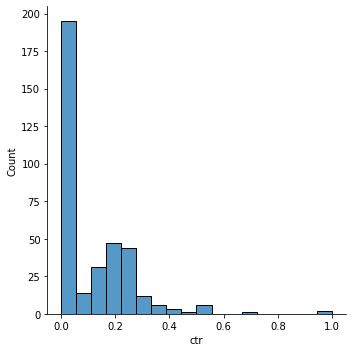

In [11]:
# 광고의 평균 CTR 분포
sns.displot(ad_statistics['ctr'])

In [12]:
# 노출수가 너무 적은 데이터의 경우 policy에 대한 신뢰도가 낮음
# 데이터가 아주 적을 때에 Bandit이 exploration을 해주긴 하지만 실제 추천을 수행할 때는 너무 적은 데이터가 쌓인 아이템은 policy를 사용하지 않음

# ad_statistics.sort_values(by = 'ctr', ascending=True)[:20]
ad_statistics.sort_values(by = 'ctr', ascending=False)[:20]

,ad,imp,click,ctr
303,23222,1,1,1.000000
24,18496,1,1,1.000000
139,22288,3,2,0.666667
250,23015,2,1,0.500000
209,22818,2,1,0.500000
308,23445,2,1,0.500000
154,22745,2,1,0.500000
251,23016,2,1,0.500000
175,22774,4,2,0.500000
276,23153,11,5,0.454545


# MAB Offline Evaluation
- 기존 추천 시스템을 구현하고 평가하는 방식과 MAB의 policy를 평가하는 방식은 다릅니다.
- 이전의 추천 모델은 train / test로 데이터를 나누어서 train 데이터로 모델을 학습하고 test 데이터로 성능을 평가했지만,
- MAB의 경우 전체 데이터를 시간 순서로 정렬한 뒤 batch 단위로 policy를 업데이트하고 다음 batch에 policy를 평가하게 됩니다.

## 평가 방식
1. 시간 순서로 정렬된 데이터를 N개 단위의 batch로 나눕니다.
2. 각 batch 마다 현재 policy에 맞게 아이템을 추천합니다.
3. 추천된 결과와 해당 결과의 실제 reward를 비교하여 cumulative rewards를 업데이트합니다.
    - 추천된 아이템과 실제 노출된 아이템이 같지 않다면 cumulative rewards를 업데이트 하지 않습니다.
    - 추천된 아이템과 실제 노출된 아이템이 같다면 cumulative rewards를 업데이트 합니다.
4. cumulative rewards를 업데이트한 뒤, 해당 batch의 데이터를 가지고 policy를 업데이트 합니다.
5. 다음 batch에서 2~4를 반복적으로 수행합니다.




In [13]:
# 광고 노출, 클릭 데이터릴 시간 순서로 정렬
mab_df = mab_df.sort_values(by = 'datetime')
mab_df['imp'] = 1

In [14]:
mab_df

,id,ad,datetime,click,imp
0,10010804179216291475,15704,2014-10-21 00:00:00,0,1
696,4251691006404076570,15707,2014-10-21 00:00:00,0,1
697,4256548079061461216,15704,2014-10-21 00:00:00,0,1
698,4256814970000693395,15705,2014-10-21 00:00:00,0,1
699,4272263715071891030,15699,2014-10-21 00:00:00,0,1
...,...,...,...,...,...
160025,15638333441364131220,22257,2014-10-30 23:00:00,0,1
160024,15612835964008476367,22254,2014-10-30 23:00:00,0,1
160023,15599245444302734215,15705,2014-10-30 23:00:00,0,1
160033,15977258595711361825,22676,2014-10-30 23:00:00,0,1


# random policy
- 매번 랜덤하게 아이템을 선택해 추천해주는 random policy로 집행했을 때 cumulative rewards를 구해봅시다
- 다른 policy의 성능에 대한 baseline으로 삼을 수 있습니다

In [15]:
recommend_size = 5
batch_size = 500
rewards = []
reward_timelines = []

for t in tqdm(range(mab_df.shape[0]//batch_size)):
    t = t * batch_size
    
    # 랜덤하게 아이템을 선택하여 추천
    recs = np.random.choice(ad_list, size=(recommend_size), replace=False)
    
    # 현재 batch의 데이터를 가져옵니다
    batch_df = mab_df[t:t+batch_size]
    
    # 추천된 아이템과 일치하는 데이터에 대해서 cumulative reward를 구합니다
    matched_action = batch_df.loc[batch_df['ad'].isin(recs)]
    if len(matched_action) > 0:
        rewards.extend(matched_action['click'].tolist())
        reward_timelines.append(np.mean(rewards))
    
print('number of offline sample:', len(rewards))
print('expected reward:', np.mean(rewards))


number of offline sample: 2112
expected reward: 0.21022727272727273


In [16]:
recs

array([23915, 22951, 22904, 22780, 23761])

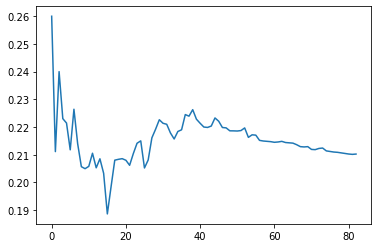

In [17]:
plt.plot(reward_timelines)

# epsilon greedy
- episilon의 확률로 랜덤하게 아이템을 선택합니다
- 1 - epsilon의 확률로 가장 CTR이 높았던 아이템을 선택하여 추천합니다
- 이 때 충분한 데이터가 확보되지 않은 아이템의 경우 greedy algorithm에서 제외합니다

In [18]:
class eGreedy:
    def __init__(self):
        self.mean = 0
        self.N = 0

    def update(self, reward):
        self.N += 1
        self.mean = (1 - 1.0 / self.N) * self.mean + 1.0 / self.N * reward

In [38]:
policy_dict = {ad: eGreedy() for ad in ad_list}
recommend_size = 5
batch_size = 500
epsilon = 0.1
rewards = []
reward_timelines = []

for t in tqdm(range(mab_df.shape[0]//batch_size+1)):
    
    t = t * batch_size    
    
    # epsilon의 확률로 0과 1가운데 하나를 뽑습니다
    explore = np.random.binomial(1, epsilon)

    if explore == 1:
        # 랜덤하게 아이템을 선택하여 추천
        recs = np.random.choice(ad_list, size=(recommend_size), replace=False).tolist()
    else:
        
        # 광고별 평균 CTR을 가져옵니다, 이 때 지금까지 수집된 데이터가 10개 이상인 것만 추출합니다
        candidates = [(ad, egreedy.mean) for ad, egreedy in policy_dict.items() if egreedy.N >= 10]
        
        # 평균 ctr 순서대로 가장 높은 아이템을 추천합니다
        candidates = sorted(candidates, key=lambda x: (x[1]), reverse=True)[:recommend_size]
        recs = [ad for ad, ctr in candidates]
        
        # 추천 아이템이 recommend_size보다 작은 경우에는 랜덤하게 나머지를 샘플링합니다
        if len(recs) < recommend_size:
            additional_recs = list(set(ad_list) - set(recs))
            additional_recs = np.random.choice(additional_recs, size=(recommend_size-len(recs)), replace=False).tolist()
            recs.extend(additional_recs)
    
    # policy를 업데이트합니다
    batch_df = mab_df[t:t+batch_size]
    for _, row in batch_df.iterrows():
        policy_dict[row['ad']].update(row['click'])

    # policy를 평가합니다
    matched_action = batch_df.loc[batch_df['ad'].isin(recs)]
    if len(matched_action) > 0:
        rewards.extend(matched_action['click'].tolist())
        reward_timelines.append(np.mean(rewards))
        
print('number of offline sample:', len(rewards))
print('expected reward:', np.mean(rewards))


number of offline sample: 12789
expected reward: 0.22511533348971774


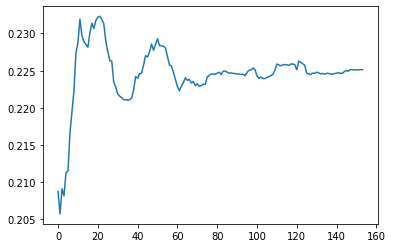

In [39]:
plt.plot(reward_timelines)

# UCB 

In [21]:
class UCB:
    def __init__(self, c):
        self.mean = 0
        self.N = 0
        self.c = c

    def update(self, reward):
        self.N += 1
        self.mean = (1 - 1.0 / self.N) * self.mean + 1.0 / self.N * reward
    
    def score(self, t):
        return self.mean + self.c * np.sqrt(np.log(t+1) / self.N)

In [36]:
c = 0.2
policy_dict = {ad: UCB(c) for ad in ad_list}
recommend_size = 5
batch_size = 500
rewards = []
reward_timelines = []

for t in tqdm(range(mab_df.shape[0]//batch_size+1)):
    
    t = t * batch_size    
        
    # 개별 광고에 대해 각각 ucb 스코어 값을 구합니다.
    candidates = [(ad, ucb.score(t)) for ad, ucb in policy_dict.items() if ucb.N >= 10]

    # ucb 스코어 순서대로 가장 높은 아이템을 추천합니다
    candidates = sorted(candidates, key=lambda x: (x[1]), reverse=True)[:recommend_size]
    recs = [ad for ad, score in candidates]

    # 추천 아이템이 recommend_size보다 작은 경우에는 랜덤하게 나머지를 샘플링합니다
    if len(recs) < recommend_size:
        additional_recs = list(set(ad_list) - set(recs))
        additional_recs = np.random.choice(additional_recs, size=(recommend_size-len(recs)), replace=False).tolist()
        recs.extend(additional_recs)
    
    # policy를 업데이트합니다
    batch_df = mab_df[t:t+batch_size]
    for _, row in batch_df.iterrows():
        policy_dict[row['ad']].update(row['click'])

    # policy를 평가합니다
    matched_action = batch_df.loc[batch_df['ad'].isin(recs)]
    if len(matched_action) > 0:
        rewards.extend(matched_action['click'].tolist())
        reward_timelines.append(np.mean(rewards))
        
print('number of offline sample:', len(rewards))
print('expected reward:', np.mean(rewards))


number of offline sample: 11542
expected reward: 0.21997920637671114


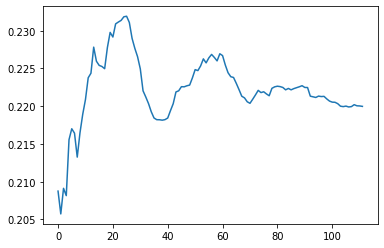

In [37]:
plt.plot(reward_timelines)

# Thompson Sampling

In [27]:
from scipy.stats import beta

class TS:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        self.N = 0

    def update(self, reward):
        self.N += 1
        if reward > 0:
            self.a += 1
        else:
            self.b += 1
    
    def sample(self):
        return beta.rvs(self.a, b + self.b, size = 1)[0]

In [34]:
a = 2; b = 8
policy_dict = {ad: TS(a, b) for ad in ad_list}
recommend_size = 5
batch_size = 500
rewards = []
reward_timelines = []

for t in tqdm(range(mab_df.shape[0]//batch_size+1)):
    
    t = t * batch_size    
        
    # 개별 광고에 대해서 beta 분포 샘플링을 통해 얻어진 score 값을 구해옵니다
    candidates = [(ad, ts.sample()) for ad, ts in policy_dict.items() if ts.N >= 10]

    # score 순서대로 가장 높은 아이템을 추천합니다
    candidates = sorted(candidates, key=lambda x: (x[1]), reverse=True)[:recommend_size]
    recs = [ad for ad, score in candidates]

    # 추천 아이템이 recommend_size보다 작은 경우에는 랜덤하게 나머지를 샘플링합니다
    if len(recs) < recommend_size:
        additional_recs = list(set(ad_list) - set(recs))
        additional_recs = np.random.choice(additional_recs, size=(recommend_size-len(recs)), replace=False).tolist()
        recs.extend(additional_recs)
    
    # policy를 업데이트합니다
    batch_df = mab_df[t:t+batch_size]
    for _, row in batch_df.iterrows():
        policy_dict[row['ad']].update(row['click'])

    # policy를 평가합니다
    matched_action = batch_df.loc[batch_df['ad'].isin(recs)]
    if len(matched_action) > 0:
        rewards.extend(matched_action['click'].tolist())
        reward_timelines.append(np.mean(rewards))
        
print('number of offline sample:', len(rewards))
print('expected reward:', np.mean(rewards))


number of offline sample: 26068
expected reward: 0.23542274052478135


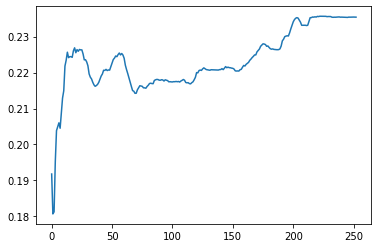

In [35]:
plt.plot(reward_timelines)